# Hurricane Damage Classification with EfficientNetB7

Original notebook is in Kaggle. If you want to use this notebook to train the model, you need to download the dataset (the link is below) and change/add some file paths.

Made by Hoang Vu and Vinh Do.

Dataset is from [Satellite Images of Hurricane Damage](https://www.kaggle.com/datasets/kmader/satellite-images-of-hurricane-damage).

## Installing dependencies

In [4]:
# Installing EfficientNet
!pip install -U efficientnet

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
from PIL import Image
from pathlib import Path
import cv2
import efficientnet.keras as efn

from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Checking the data

In [6]:
# Append data into dataframe
PATH = "/kaggle/input/satellite-images-of-hurricane-damage/"

# example path: "/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/-95.656807_29.835212.jpeg"
image_df = pd.DataFrame()
image_list = list(Path(PATH).glob('**/*.jp*g'))

image_df['path'] = image_list
image_df['label'] = image_df['path'].map(lambda x: int(1) if x.parent.stem == 'damage' else int(0))
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split("_")[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split("_")[1]))
image_df['type'] = image_df['path'].map(lambda x: x.parent.parent.stem)

In [7]:
# Check number of images with label 1
print(len(image_df[image_df['label'] == 1]['label']))

15000


In [8]:
# Check image size and color
img = cv2.imread(str(image_list[0]))
print("Type of image is: ", type(img))
print("Shape of image is: ", img.shape)

Type of image is:  <class 'numpy.ndarray'>
Shape of image is:  (128, 128, 3)


## Separating into dataframes

In [9]:
train_df = image_df[image_df['type'] == 'train_another']
val_df = image_df[image_df['type'] == 'validation_another']
test_df = image_df[image_df['type'] == 'test']

In [10]:
X_train = np.array(list(cv2.imread(str(s), cv2.IMREAD_UNCHANGED) for s in train_df['path']), dtype=np.float32)
X_train /= 255.
y_train = train_df['label']

X_val = np.array(list(cv2.imread(str(s), cv2.IMREAD_UNCHANGED) for s in val_df['path']), dtype=np.float32)
X_val /= 255.
y_val = val_df['label']

X_test = np.array(list(cv2.imread(str(s), cv2.IMREAD_UNCHANGED) for s in test_df['path']), dtype=np.float32)
X_test /= 255.
y_test = test_df['label']

## Data Augmentation

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

## Loading model

In [26]:
eff_net = efn.EfficientNetB7(
        input_shape=(128, 128, 3),
        weights='imagenet',
        include_top=False)

In [27]:
final_model = Sequential([
    eff_net,
    Flatten(),
    Dense(units = 1024, activation = 'relu'),
    Dropout(0.5),
    Dense(units = 1, activation = 'sigmoid')
])

In [14]:
"""
model = efn.EfficientNetB7(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')
for layer in model.layers:
    layer.trainable = True

x = model.output
x = Flatten()(x)
x = Dense(units = 1024, activation = 'relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)
final_model = Model(inputs = model.input, outputs = predictions)
"""

"\nmodel = efn.EfficientNetB7(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')\nfor layer in model.layers:\n    layer.trainable = True\n\nx = model.output\nx = Flatten()(x)\nx = Dense(units = 1024, activation = 'relu')(x)\nx = Dropout(0.5)(x)\n\npredictions = Dense(1, activation='sigmoid')(x)\nfinal_model = Model(inputs = model.input, outputs = predictions)\n"

In [28]:
loss = 'binary_crossentropy'
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
metrics = ['accuracy']

final_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

In [29]:
datagen.fit(X_train)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              verbose=0,
                              restore_best_weights=True)

In [17]:
print(X_train.shape)
print(y_train.shape)

(10000, 128, 128, 3)
(10000,)


In [30]:
history = final_model.fit(datagen.flow(X_train, y_train, batch_size = 50),
                          epochs = 5,
                          validation_data = (X_val, y_val),
                          callbacks = [learning_rate_reduction, early_stopping]
                         )

Epoch 1/5


2023-09-15 06:18:34.706006: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnet-b7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 247s 939ms/step - loss: 1.4030 - accuracy: 0.8468 - val_loss: 42.2920 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - 180s 902ms/step - loss: 0.6871 - accuracy: 0.9062 - val_loss: 23.5039 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - 178s 888ms/step - loss: 0.5438 - accuracy: 0.9293 - val_loss: 22.5089 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 4/5
200/200 [==============================] - 180s 901ms/step - loss: 0.3950 - accuracy: 0.9518 - val_loss: 0.0949 - val_accuracy: 0.9765 - lr: 0.0010
Epoch 5/5
200/200 [==============================] - 177s 885ms/step - loss: 0.1487 - accuracy: 0.9565 - val_loss: 0.1345 - val_accuracy: 0.9525 - lr: 0.0010


## Show results

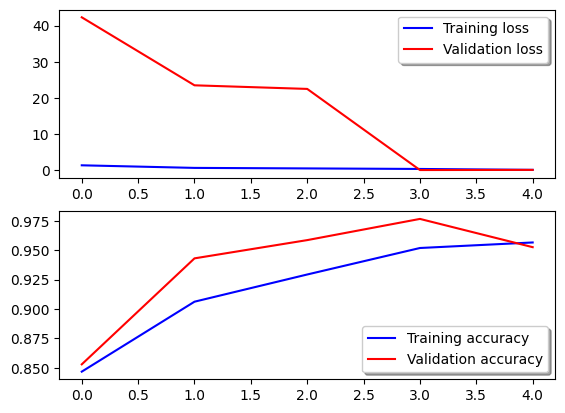

In [31]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)


ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

## Test prediction

In [32]:
print(X_test[0].shape)

(128, 128, 3)


In [33]:
results = final_model.predict(X_test[0:100].reshape(-1, 128, 128, 3))
yhat = (results >= 0.5).astype(int)

4/4 [==============================] - 6s 123ms/step


In [34]:
yhat = yhat[:,0]
final_acc = np.sum(yhat == y_test[0:100]) / len(yhat)
print("Final accuracy is: ", final_acc * 100, "%.")

Final accuracy is:  100.0 %.


## Output model

In [23]:
model_json = final_model.to_json()
with open("/kaggle/working/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
final_model.save_weights("/kaggle/working/model.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
final_model.save("/kaggle/working/epoch5_model.keras")

In [24]:
"""
import pickle
output_path = "/kaggle/working/"
file_path = output_path + 'model.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(final_model, file)
"""

'\nimport pickle\noutput_path = "/kaggle/working/"\nfile_path = output_path + \'model.pkl\'\n\nwith open(file_path, \'wb\') as file:\n    pickle.dump(final_model, file)\n'